In [ ]:
import os
import sys
import pdb
import numpy as np
import scipy.interpolate
import scipy.io

import matplotlib.pyplot as plt


In [2]:
def shapedfilter_hrtf(sdelay, freq, gain, fs, ctap, ctap2):
    """
    """
    sdelay = sdelay.reshape((-1, 1)) # Ensure sdelay is an M x 1 matrix
    assert np.all(sdelay >= 0), "The sample delay must be positive"
    ntaps = 2 * ctap - 1
    N = ctap - 1
    fc = 0.9
    # Design the non-integer delay filter
    x = np.ones((1, ntaps))
    x[0, 0] = 0
    x = np.matmul(np.ones(sdelay.shape), np.arange(-N, N + 1).reshape((1, -1))) - np.matmul(sdelay, x)
    h = 0.5 * fc * (1 + np.cos(np.pi * x / N)) * np.sinc(fc * x)
    freq = freq.reshape((-1)) # Ensure freq is a vector
    if ctap2 > 1:
        df = np.arange(0, ctap2) * (np.pi / (ctap2 - 1)) # Determine FFT points
        freq = np.array([-np.spacing(1)] + list(2 * np.pi * freq) + [np.pi])
        gain = np.concatenate([gain[:, :1], gain, gain[:, -1:]], axis=1)
        # Interpolate reflection frequency-dependence to get gains at FFT points
        G = scipy.interpolate.interp1d(freq.reshape([-1]), gain)(df)
        # Combine the non-integer delay filter and the wall/sphere filter
        G[:, ctap2-1] = np.real(G[:, ctap2-1])
        # Transform into appropriate wall transfer function
        G = np.concatenate([G, np.conj(G[:, 1:ctap2-1])[:, ::-1]], axis=1)
        gt = np.real(np.fft.ifft(G.T, axis=0))
        # Zero-pad and FFT
        g = np.concatenate([
            0.5 * gt[(ctap2-1):(ctap2), :],
            gt[ctap2 : (2 * ctap2 - 2), :],
            gt[0 : ctap2 - 1, :],
            0.5 * gt[(ctap2-1):(ctap2), :],
            np.zeros((2 * ctap - 2, gt.shape[1])),
        ], axis=0)
        G = np.fft.fft(g, axis=0)
        # Zero-pad and FFT the delay filter
        H = np.fft.fft(
            np.concatenate([
                h.T,
                np.zeros((2 * ctap2 - 2, gt.shape[1])),
            ], axis=0),
            axis=0
        )
        # Convolve wall transfer function and delay filter
        HOUT = H * G
        # Obtain total impulse response
        hout = np.real(np.fft.ifft(HOUT, axis=0)).T
    else:
        # Scale impulse response only if wall reflections are
        # frequency-independent and sphere is not present
        hout = h * np.matmul(gain[:, 0], np.ones(h[0:1, :].shape))
    return hout


sdelay = np.array([0.411119294090895, 0.600165773186745])
gain = np.array([
    [0.013462743344629,0.056313514709473,0.137448031335961,0.278500976009402,0.483982307179293,0.664832635991501],
    [0.008750783174009,0.042235136032104,0.112707385695488,0.245080858888274,0.450103545676742,0.638239330551840],
])
freq = np.array([0.002834467120181,0.005668934240363,0.011337868480726,0.022675736961451,0.045351473922902,0.090702947845805])
fs = 44100
ctap = 11
ctap2 = 33
hout = shapedfilter_hrtf(sdelay, freq, gain, fs, ctap, ctap2)


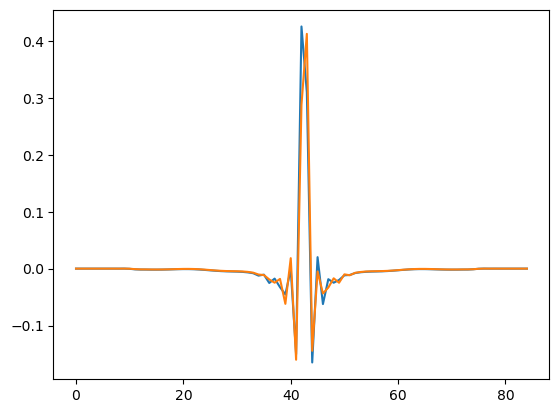

In [3]:
fig, ax = plt.subplots()
ax.plot(hout.T)
plt.show()


In [43]:
import port
import importlib
importlib.reload(port)


def room_impulse_hrtf(
        src_loc=[5, 5, 5],
        head_center=[2, 2, 2],
        head_azimuth=0,
        meas_sym=1,
        walls=[10, 10, 10],
        wtypes=[3, 3, 3, 3, 3, 3],
        sr=44100,
        c=344.5,
        dur=0.5,
        log_dist=False,
        jitter=True,
        highpass=True):
    """
    """
    meas_files = scipy.io.loadmat('HRTFs/file_names.mat')['gardnermartin_file']
    meas_locs = scipy.io.loadmat('HRTFs/data_locs.mat')['locs_gardnermartin']
    
    src = np.array(src_loc, dtype=float)
    h_cent = np.array(head_center, dtype=float)
    h_az = np.array(head_azimuth, dtype=float)
    m_locs = np.array(meas_locs, dtype=float)
    m_files = meas_files
    L = meas_locs.shape[0]
    m_delay = (np.sqrt(np.sum(np.square(src - h_cent))) / c) * np.ones((L,))
    m_sym = np.array(meas_sym)

    # Frequency-dependent reflection coefficients for each wall
    fgains = np.zeros((6, 6), dtype=float)
    for itr_wall, material in enumerate(wtypes):
        alpha, freq = port.acoeff_hrtf(material=material)
        fgains[itr_wall, :] = np.sqrt(1 - alpha)
    uniform_walls = len(np.unique(fgains)) == 1 # True when fgains is frequency-independent
    
    nfreq = freq / sr # Frequencies as a fraction of sampling rate
    ntaps = int(sr * dur) # Number of taps in output BRIR
    
    """
    Part I: Initialization
    """
    ctap = 11 # Center tap of lowpass to create non-integer delay impulse (as in Peterson)
    if uniform_walls:
        ctap2 = 1 # If walls are uniform, use a single-tap filter to scale gain
    else:
        ctap2 = 33 # For frequency-dependent wall reflections, use a longer filter
    
    num_rec = 2 # Number of ears
    
    # Convert measured HRTF locations into room (xyz) coordinates (and log distance locations)
    m_locs_xyz = np.ones_like(m_locs)
    m_locs_xyz[:, 0] = m_locs[:, 0] * np.cos(np.deg2rad(m_locs[:, 1] + h_az)) * np.cos(np.deg2rad(m_locs[:, 2]))
    m_locs_xyz[:, 1] = m_locs[:, 0] * -np.sin(np.deg2rad(m_locs[:, 1] + h_az)) * np.cos(np.deg2rad(m_locs[:, 2]))
    m_locs_xyz[:, 2] = m_locs[:, 0] * np.sin(np.deg2rad(m_locs[:, 2]))
    m_locs_xyz = m_locs_xyz + h_cent.reshape([1, -1]);
    m_locs_xyz_logdist = np.ones_like(m_locs)
    m_locs_xyz_logdist[:, 0] = (np.log(m_locs[:, 0]) - np.log(0.05)) * np.cos(np.deg2rad(m_locs[:, 1] + h_az)) * np.cos(np.deg2rad(m_locs[:, 2]))
    m_locs_xyz_logdist[:, 1] = (np.log(m_locs[:, 0]) - np.log(0.05)) * -np.sin(np.deg2rad(m_locs[:, 1] + h_az)) * np.cos(np.deg2rad(m_locs[:, 2]))
    m_locs_xyz_logdist[:, 2] = (np.log(m_locs[:, 0]) - np.log(0.05)) * np.sin(np.deg2rad(m_locs[:, 2]))
    m_locs_xyz_logdist = m_locs_xyz_logdist + h_cent.reshape((1, -1));
    
    # Calculate the number of lead zeros to strip
    idx_min = np.argmin(np.sqrt(np.sum(np.square(src.reshape((1, -1)) - m_locs_xyz), axis=1)))
    src_mloc = m_locs_xyz[idx_min, :] # Nearest measured loc or direct path
    rel_dist = np.linalg.norm(src - h_cent, 2) - np.linalg.norm(src_mloc - h_cent, 2)
    lead_zeros = m_delay[idx_min] + np.floor(sr * rel_dist / c)
    
    # Initialize output matrix (will later truncate to exactly ntaps in length)
    _, ht = scipy.io.wavfile.read(meas_files[0].replace('\\', '/').replace(' ', ''))
    h = np.zeros((ntaps + ctap + ctap2 + ht.shape[0], num_rec), dtype=float)
    
    """
    Part II: determine source image locations and corresponding impulse
    response contribution from each source.  To speed up process yet ease
    the computational burden, for every 10000 source images, break off and
    determine impulse response.
    
    The algorithm for determining source images is as follows:
    1. Calculate maximum distance which provides relevant sources
        (i.e., those that arrive within the imp_resp duration)
    2. By looping through the X dimension, generate images of
        the (0,0,0) corner of the room, restricting the
        distance below the presecribed level.
    3. Use the coordinates of each (0,0,0) image to generate 8
        source images
    4. Generate corresponding number of reflections from each wall
        for each source image.
    """
    
    # Maximum source distance to be in impulse response
    dmax = np.ceil((ntaps + lead_zeros) * c / fs + np.max(walls))
    s_locations = np.ones((20000, 3), dtype=float) # Initialize locations matrix
    s_reflects = np.ones((20000, 6), dtype=float) # Initialize reflections matrix
    # Vector to get locations from the (0, 0, 0) corner images
    src_pts = np.array([
        [ 1,  1,  1],
        [ 1,  1, -1],
        [ 1, -1,  1],
        [ 1, -1, -1],
        [-1,  1,  1],
        [-1,  1, -1],
        [-1, -1,  1],
        [-1, -1, -1],
    ], dtype=float) * src.reshape((1, -1))
    Nx = np.ceil(dmax / (2 * walls[1])) # Appropriate number of (0, 0, 0)
    
    loc_num = 0
    for nx in np.arange(Nx, -1, -1, dtype=int):
        if nx < Nx:
            ny = int(np.ceil(np.sqrt(np.square(dmax) - np.square(nx * 2 * walls[0])) / (2 * walls[1])))
            nz = int(np.ceil(np.sqrt(np.square(dmax) - np.square(nx * 2 * walls[0])) / (2 * walls[2])))
        else:
            ny = 0
            nz = 0        
        X = nx * np.ones(((2 * ny + 1) * (2 * nz + 1), 1), dtype=float) # Form images of (0,0,0)
        Y = np.matmul(
            np.arange(-ny, ny + 1, dtype=float).reshape((-1, 1)),
            np.ones((1, 2 * nz + 1), dtype=float)).reshape((-1, 1))
        Z = np.matmul(
            np.ones((2 * ny + 1, 1), dtype=float),
            np.arange(-nz, nz + 1, dtype=float).reshape((1, -1))).reshape((-1, 1))
        if nx != 0:
            # If nx !=0, do both +nx and -nx
            X = np.concatenate([-X, X], axis=0) # Images of (0, 0, 0)
            Y = np.concatenate([Y, Y], axis=0)
            Z = np.concatenate([Z, Z], axis=0)
        Xw = 2 * walls[0] * X
        Yw = 2 * walls[1] * Y
        Zw = 2 * walls[2] * Z
        
        # For each image of (0, 0, 0), get the 8 source images and number of reflections at each wall
        for k in range(8):
            s_refls = np.zeros((X.shape[0], 6), dtype=float)
            s_locs = np.concatenate([Xw, Yw, Zw], axis=1) + src_pts[k, :].reshape((1, -1))
            s_refls[:, 0:1] = (src_pts[k, 0] > 0) * np.abs(X) + (src_pts[k, 0] < 0) * np.abs(X - 1)
            s_refls[:, 1:2] = np.abs(X)
            s_refls[:, 2:3] = (src_pts[k, 1] > 0) * np.abs(Y) + (src_pts[k, 1] < 0) * np.abs(Y - 1)
            s_refls[:, 3:4] = np.abs(Y)
            s_refls[:, 4:5] = (src_pts[k, 2] > 0) * np.abs(Z) + (src_pts[k, 2] < 0) * np.abs(Z - 1)
            s_refls[:, 5:6] = np.abs(Z)
            
            while (loc_num + s_locs.shape[0]) > 20000:
                m = 20000 - loc_num
                s_locations[slice(loc_num, loc_num + m), :] = s_locs[slice(0, m), :]
                s_reflects[slice(loc_num, loc_num + m), :] = s_refls[slice(0, m), :]
                # Get impulse response contributions
                h, s_locations = impulse_generate_hrtf(
                    h,
                    src,
                    h_cent,
                    h_az,
                    s_locations,
                    s_reflects,
                    L,
                    m_locs,
                    m_locs_xyz,
                    m_locs_xyz_logdist,
                    m_files, m_delay, m_sym, sr, c, ntaps, log_dist,
                    ctap, ctap2, fgains, nfreq, lead_zeros, jitter)
                loc_num = 0 # Reset loc_num counter and continue
                s_locs = s_locs[slice(m, s_locs.shape[0]), :]
                s_refls = s_refls[slice(m, s_refls.shape[0]), :]
            
            s_locations[slice(loc_num, loc_num + s_locs.shape[0]), :] = s_locs
            s_reflects[slice(loc_num, loc_num + s_refls.shape[0]), :] = s_refls
            loc_num = loc_num + s_locs.shape[0]
    
    # When all locations have been generated, process the final ones
    s_locations = s_locations[0:loc_num, :]
    s_reflects = s_reflects[0:loc_num, :]
    h, s_locations = impulse_generate_hrtf(
        h,
        src,
        h_cent,
        h_az,
        s_locations,
        s_reflects,
        L,
        m_locs,
        m_locs_xyz,
        m_locs_xyz_logdist,
        m_files, m_delay, m_sym, sr, c, ntaps, log_dist,
        ctap, ctap2, fgains, nfreq, lead_zeros, jitter)
    
    """
    Part III: Finalize output
    """
    if highpass:
        # Highpass filter if desired
        b, a = scipy.signal.butter(2, 0.005, btype='high')
        h = scipy.signal.lfilter(b, a, h, axis=0)
    # Restrict to `ntaps` in length
    hout = h[:ntaps, :]
    return hout


def impulse_generate_hrtf(
        h,
        src,
        h_cent,
        h_az,
        s_locations,
        s_reflects,
        L,
        m_locs,
        m_locs_xyz,
        m_locs_xyz_logdist,
        m_files, m_delay, m_sym, sr, c, ntaps, log_dist,
        ctap, ctap2, fgains, nfreq, lead_zeros, jitter):
    """
    """
    jitter_reflects = 5
    
    """
    Part I: Form variables to be used in impulse response generation
    """
    # Determine overall source gains (based on number of reflections
    # through each wall) for each source location.
    gains = np.ones((s_locations.shape[0], nfreq.shape[0]), dtype=float)
    for itr_wall in range(6):
        gains = gains * np.power(fgains[itr_wall:itr_wall + 1, :], s_reflects[:, itr_wall:itr_wall + 1])
    # If m_sym is active, convert 180° to 360° sources to 0° to 180° sources
    s_locations_relh = s_locations - h_cent.reshape((1, -1))
    s_locations_pol = np.zeros_like(s_locations)
    s_locations_pol[:, 0] = np.sqrt(np.sum(np.square(s_locations_relh), axis=1))
    s_locations_pol[:, 1] = np.rad2deg(np.angle(s_locations_relh[:, 0] - 1j * s_locations_relh[:, 1])) - h_az
    s_locations_pol[:, 2] = np.rad2deg(np.arcsin(s_locations_relh[:, 2] / s_locations_pol[:, 0]))
    if m_sym:
        flip = s_locations_pol[:, 1] < 0
        s_locations_pol[:, 1] = np.abs(s_locations_pol[:, 1])
        r = s_locations_pol[:, 0]
        s_locations = np.stack([
            r * np.cos(np.deg2rad(s_locations_pol[:, 1])) * np.cos(np.deg2rad(s_locations_pol[:, 2])),
            r * -np.sin(np.deg2rad(s_locations_pol[:, 1])) * np.cos(np.deg2rad(s_locations_pol[:, 2])),
            r * np.sin(np.deg2rad(s_locations_pol[:, 2])),
        ], axis=1)
        s_locations = s_locations + h_cent.reshape((1, -1))
    else:
        flip = zeros((s_locations.shape[0]), dtype=bool)
    
    # If log_dist is active, form s_locations_logdist
    if log_dist:
        r = np.log(s_locations_pol[:, 0]) - np.log(0.05)
        s_locations_logdist = np.stack([
            r * np.cos(np.deg2rad(s_locations_pol[:, 1])) * np.cos(np.deg2rad(s_locations_pol[:, 2])),
            r * -np.sin(np.deg2rad(s_locations_pol[:, 1])) * np.cos(np.deg2rad(s_locations_pol[:, 2])),
            r * np.sin(np.deg2rad(s_locations_pol[:, 2])),
        ], axis=1)
        s_locations_logdist = s_locations_logdist + h_cent.reshape((1, -1))
        D = m_locs_xyz_logdist[:, np.newaxis, :] - s_locations_logdist[np.newaxis, :, :]
    else:
        D = m_locs_xyz[:, np.newaxis, :] - s_locations[np.newaxis, :, :]
    # For each source, determine the closest measurement spot
    D = np.sqrt(np.sum(np.square(D), axis=2))
    near_m_loc = np.argmin(D, axis=0)
    
    """
    Part II: Based on the center of the head, introduce a 
    1 percent jitter to add into all source-to-mic distances
    that are reflected by more than 5 walls (if jitter flag)
    """
    if jitter:
        jitt = np.random.randn(s_locations_pol.shape[0])
        jitt[s_reflects.sum(axis=1) < jitter_reflects] = 0
        s_locations_pol[:, 0] = s_locations_pol[:, 0] + jitt
    # Calculate the relative additional distance between each
    # (jittered) source and the corresponding measurement location
    rel_dist = s_locations_pol[:, 0] - m_locs[near_m_loc, 0]
    
    """
    Part III: For each measurement location, generate impulse
    response from corresponding sources to meas loc.  Then
    incorporate HRTFs.  Treat flips and no flips accordingly.
    """
    (h1, h2) = h.shape
    hrtf_temp = np.zeros((L, h1, h2), dtype=float)
    numColsInB = hrtf_temp.shape[1]
    
    for l in range(L):
        IDX_l = near_m_loc == l
        if IDX_l.sum() > 0:
            IDX_noflip = np.logical_and(IDX_l, ~flip)
            IDX_flip = np.logical_and(IDX_l, flip)
            h_noflip = np.zeros_like(h)
            h_flip = np.zeros_like(h)
            
            # Treat non-flipped sources
            if IDX_noflip.sum() > 0:
                # Get sample delays to the measured location
                thit = ctap + ctap2 - lead_zeros + m_delay[l] + (rel_dist[IDX_noflip] * fs / c)
                ihit = np.floor(thit)
                fhit = thit - ihit
                gains_noflip = gains[IDX_noflip, :]
                # Get scale factors to account for distance traveled
                m_sc = 1 / m_locs[near_m_loc[IDX_noflip], 0]
                s_sc = 1 / s_locations_pol[IDX_noflip, 0]
                rel_sc = s_sc / m_sc
                # Eliminate locations that are too far away to enter into impulse response
                v = ihit <= ntaps + ctap + ctap2
                if v.sum() > 0:
                    # Initialize temporary impulse response vector
                    ht = np.zeros((h.shape[0] + ctap + 1 + ctap2 + 1, 1), dtype=float)
                    # Indices into ht. Each row corresonds to one source image location, with the center
                    # determined by ihit. Within a row, there are (2 * ctap - 1) + (2 * ctap2 - 1) - 1 values
                    # that account for non-integer dela, fhit, and for frequency-dependent wall reflections /
                    # sphere diffraction
                    ht_ind = ihit[v].reshape(-1, 1) * np.ones((1, 2 * ctap - 1 + 2 * ctap2 - 1 - 1))
                    ht_ind = ht_ind + np.arange(-ctap - ctap2 + 1 + 1, ctap + ctap2 - 1).reshape((1, -1))
                    ht_ind = ht_ind.astype(int)
                    # For each source location, determine the impulse response (generate filter to
                    # incorporate frequency gains, non-integer delay and scattering off rigid sphere
                    h_temp = rel_sc[v].reshape(-1, 1) * shapedfilter_hrtf(
                        fhit[v],
                        nfreq,
                        gains_noflip[v],
                        sr,
                        ctap,
                        ctap2)
                    # Add impulse response segments into the overall impulse response
                    for k in range(v.sum()):
                        ht[ht_ind[k], 0] = ht[ht_ind[k], 0] + h_temp[k, :]
                    # Incorporate HRTF impulse response and add into overall impulse response matrix
                    _, hrtf = scipy.io.wavfile.read(m_files[l].replace('\\', '/').replace(' ', ''))
                    new_vals = np.stack([
                        scipy.signal.fftconvolve(ht[:h.shape[0], 0], hrtf[:, 0], mode='same'),
                        scipy.signal.fftconvolve(ht[:h.shape[0], 0], hrtf[:, 1], mode='same'),
                    ], axis=1)
                    hrtf_temp[l, :, :] = hrtf_temp[l, :, :] + new_vals;
    h = h + hrtf_temp.sum(axis=0)
    return h, s_locations

hout = room_impulse_hrtf()
print('END')
# fig, ax = plt.subplots()
# ax.plot(hout)
# plt.show()


END


In [ ]:
gains = np.ones((6, 6))
s_reflects = np.ones((20000, 6))
itr_wall = 0

x = 
y = 
print(gains.shape)
print(x.shape)
print(y.shape)


